In [2]:
#import libraries
import numpy as np
import scipy as scp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas
from pandas import DataFrame
import gzip
import re
import pydot
from sklearn.externals.six import StringIO
from sklearn import tree
from sklearn import cross_validation
from sklearn import metrics
from sklearn import calibration

%matplotlib inline


In [3]:
train_data_frame = pandas.read_csv("data/train.csv", sep=",", quotechar='"')
test = pandas.read_csv("data/test.csv", sep=",", quotechar='"')

# Extract year, day and hour from timestamp and create "Year", "Month", "Hour" columns in train_data_frame

def parse_date(date):
    """
    maps date formatted as in training set as a list of [Year, Month, Hour]
    :param date: date as formatted in training set
    :retuap oject that can extract of Year, Month and Hour
    """
    mo=re.search(r'^([0-9]{4})-([0-9]{2})-[0-9]{2}\s+([0-9]{2}):[0-9]{2}:[0-9]{2}$',date)
    timelist = map(int,(mo.group(1),mo.group(2),mo.group(3)))
    return map(int,(mo.group(1),mo.group(2),mo.group(3)))

# Extract 'Year', 'Month' and 'Hour' columns for later use
train_data_frame['Year'],train_data_frame['Month'],train_data_frame['Hour'] = zip(*train_data_frame.loc[:,'Dates'].map(parse_date))
test['Year'],test['Month'],test['Hour'] = zip(*test.loc[:,'Dates'].map(parse_date))

# Clean data : supress data outliers from dataframe
train_data_frame_ret = train_data_frame[train_data_frame.Y < 38]

In [3]:
def convertToSubmittable(prediction):
    """
    Transforms a column of predictions as a number associated to a Crime Category (between 0 and 38)
    into a dataframe filled with 0s except 1 coding the predicted Crime Category in the corresponding column
    :param prediction: 1 dimensional ndarray with values in [0:38]
    :return submittable: 2 dimensional ndarray with {columns : Crime Categories, rows : Predictions}
    """
    submittable = np.zeros((len(prediction),len(crimeCategoryList)))
    for i in range(len(prediction)):
        submittable[i][prediction[i]] = 1
    return submittable

    
def prepend(filename, line):
    """
    adds line to first column of first row of csv filename
    :type filename: String
    :type line: String
    :param filename: path to csv file
    :param line: String to be added
    """
    # r+ allows file to be read and written
    with open(filename, 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write(line.rstrip('\r\n')+ content)
        
def tocsv(submission,filename):
    """
    converts 2d dataframe or ndarray to csv file named filename
    :type submission: ndarray
    :param submision:that contains probabilities of belonging to various Crime Categories
    :param filename: path to csv file 
    """
    keys = np.unique(train_data_frame["Category"])
    DataFrame(dict(zip(keys, submission.T))).to_csv(filename)


def gzipcompress(filename):
    """
    compresses csv to gzip in same folder 
    :param filename: path to csv file
    """
    with open(filename, 'rb') as f_in:
        with gzip.open(filename[:-3]+"gz", 'wb') as f_out:
            f_out.writelines(f_in)

# Criterion Selection

<p><b>Compute logloss for various min_sample_split </b></p>
<p>criterion : gini </p>
<p>features : Hour as int, PdDistrict as dummy</p>
<p>calibration : False</p>

In [5]:
#computes cross validation

df=pandas.get_dummies(train_data_frame_ret[["Hour","PdDistrict"]])

scores = []
params = []
for k in range(10, 20100, 1000):
    treeClassifier = tree.DecisionTreeClassifier(min_samples_split=k, criterion="gini")
    score = cross_validation.cross_val_score(treeClassifier, df,
                                             np.ravel(train_data_frame_ret[["Category"]]),
                                             cv=5, scoring='log_loss')
    scores += [score.mean()]
    params += [k]
    print(k, scores)

10 [-2.6156463894961961]
1010 [-2.6156463894961961, -2.6152868471496418]
2010 [-2.6156463894961961, -2.6152868471496418, -2.6134158510707559]
3010 [-2.6156463894961961, -2.6152868471496418, -2.6134158510707559, -2.6115042562600239]
4010 [-2.6156463894961961, -2.6152868471496418, -2.6134158510707559, -2.6115042562600239, -2.6093668278269946]
5010 [-2.6156463894961961, -2.6152868471496418, -2.6134158510707559, -2.6115042562600239, -2.6093668278269946, -2.6069010316185941]
6010 [-2.6156463894961961, -2.6152868471496418, -2.6134158510707559, -2.6115042562600239, -2.6093668278269946, -2.6069010316185941, -2.6050278338437471]
7010 [-2.6156463894961961, -2.6152868471496418, -2.6134158510707559, -2.6115042562600239, -2.6093668278269946, -2.6069010316185941, -2.6050278338437471, -2.6030739374895724]
8010 [-2.6156463894961961, -2.6152868471496418, -2.6134158510707559, -2.6115042562600239, -2.6093668278269946, -2.6069010316185941, -2.6050278338437471, -2.6030739374895724, -2.6012808404327217]
901

<p><b>Compute logloss for various min_sample_split </b></p>
<p>criterion : entropy </p>
<p>features : Hour as int, PdDistrict as dummy</p>
<p>calibration : False</p>

In [6]:
df=pandas.get_dummies(train_data_frame_ret[["Hour","PdDistrict"]])

scores = []
params = []
for k in range(10, 20100, 1000):
    treeClassifier = tree.DecisionTreeClassifier(min_samples_split=k, criterion="entropy")
    score = cross_validation.cross_val_score(treeClassifier, df,
                                             np.ravel(train_data_frame_ret[["Category"]]),
                                             cv=5, scoring='log_loss')
    scores += [score.mean()]
    params += [k]
    print(k, scores)

10 [-2.6156463894961961]
1010 [-2.6156463894961961, -2.6153119977272463]
2010 [-2.6156463894961961, -2.6153119977272463, -2.6141176473905121]
3010 [-2.6156463894961961, -2.6153119977272463, -2.6141176473905121, -2.6116286045200812]
4010 [-2.6156463894961961, -2.6153119977272463, -2.6141176473905121, -2.6116286045200812, -2.6091501875338698]
5010 [-2.6156463894961961, -2.6153119977272463, -2.6141176473905121, -2.6116286045200812, -2.6091501875338698, -2.6068123251688085]
6010 [-2.6156463894961961, -2.6153119977272463, -2.6141176473905121, -2.6116286045200812, -2.6091501875338698, -2.6068123251688085, -2.6047501103255422]
7010 [-2.6156463894961961, -2.6153119977272463, -2.6141176473905121, -2.6116286045200812, -2.6091501875338698, -2.6068123251688085, -2.6047501103255422, -2.6030328517439489]
8010 [-2.6156463894961961, -2.6153119977272463, -2.6141176473905121, -2.6116286045200812, -2.6091501875338698, -2.6068123251688085, -2.6047501103255422, -2.6030328517439489, -2.6005520796293458]
901

# Submission 4

In [ ]:
# Decision Tree Classifier : http://machinelearningmastery.com/get-your-hands-dirty-with-scikit-learn-now/

treeClassifier = tree.DecisionTreeClassifier(min_samples_leaf =22000, criterion="entropy")
df=pandas.get_dummies(train_data_frame_ret[["Hour","PdDistrict"]], columns = train_data_frame_ret[["Hour","PdDistrict"]])

treeClassifier = tree.DecisionTreeClassifier(min_samples_split=k)
calibrator = calibration.CalibratedClassifierCV(treeClassifier)

trainedModel = calibrator.fit(df , train_data_frame_ret["Category"])
dftest=pandas.get_dummies(test[["Hour","PdDistrict"]], columns = train_data_frame_ret[["Hour","PdDistrict"]])
prediction2 = trainedModel.predict_proba(dftest)
print(prediction2)
print(len(prediction2))

tocsv(prediction2,"data\\Results\\decisiontree_v4.csv")
print(type(prediction2))
prepend("data\\Results\\decisiontree_v4.csv","Id")
gzipcompress("data\\Results\\decisiontree_v4.csv")



# Submission 5

In [ ]:
# Decision Tree Classifier : http://machinelearningmastery.com/get-your-hands-dirty-with-scikit-learn-now/

treeClassifier = tree.DecisionTreeClassifier(min_samples_leaf = 4000)
#df=pandas.get_dummies(train_data_frame_ret[["Hour","PdDistrict"]])


trainedModel = treeClassifier.fit(df, train_data_frame_ret["Category"])
dftest=pandas.get_dummies(test[["PdDistrict","Hour"]])
prediction2 = trainedModel.predict_proba(dftest)
print(prediction2)
print(len(prediction2))

tocsv(prediction2,"data\\Results\\decisiontree_v5.csv")
prepend("data\\Results\\decisiontree_v5.csv","Id")
gzipcompress("data\\Results\\decisiontree_v5.csv")

[-2.6702004339404866, -2.6674759781271518, -2.6845525979493092, -2.690324566573735, -2.6890074116463301, -2.6864714294509424, -2.6909010400894848, -2.693506505879748, -2.7001999398471672, -2.7007137516044226, -2.699989305099213, -2.6900137630307217]


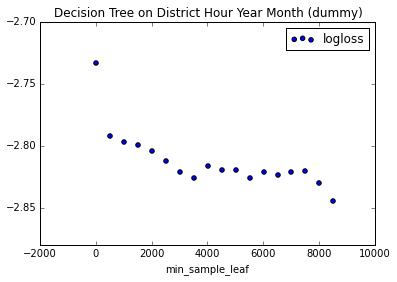

In [9]:
plt.scatter(params1,scores1)
plt.title('Decision Tree on District Hour Year Month (dummy)')
plt.legend(["logloss"])
plt.xlabel("min_sample_leaf")
print(scores)
#plt.savefig("graphs\\loglosscurves\\PdDistrictHourMonthYearDummyEntropy.pdf")

## Tree Visualization

In [7]:
# allows data visualization by exporting tree to pdf format
for k in range(1,800000,100000):
    treeClassifier = tree.DecisionTreeClassifier(min_samples_split=k)
    treeClassifier.fit(df, train_data_frame_ret.Category)
    dot_data = StringIO() 
    tree.export_graphviz(treeClassifier, out_file=dot_data, feature_names=df.columns)
    graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
    graph.write_pdf("graphs\\treev3splitPdDistricHour"+str(k)+".pdf")
